In [ ]:
!unzip -q '/content/trafficsigns_dataset 2.zip'

In [ ]:
!pip -q install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


# **Import Libraries**

In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
import imgaug as ia
from imgaug import augmenters as iaa
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import joblib
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

<ipython-input-3-70f62cf426c3>:25: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# **Check Directories Structure**



In [ ]:
def print_directory_names(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        level = dirpath.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print('{}{}/'.format(indent, os.path.basename(dirpath)))

extract_path = './trafficsigns_dataset'
print_directory_names(extract_path)

trafficsigns_dataset/
    square/
        laneend/
        parking/
        continue/
        crossing/
    diamond/
        rightofway/
    triangle/
        warning/
        giveway/
    round/
        bicycle/
        roundabout/
        trafficdirective/
        limitedtraffic/
        noparking/
        speed/
        traveldirection/
        noentry/
    trafficsigns_dataset/
        square/
            laneend/
            parking/
            continue/
            crossing/
        diamond/
            rightofway/
        triangle/
            warning/
            giveway/
        round/
            bicycle/
            roundabout/
            trafficdirective/
            limitedtraffic/
            noparking/
            speed/
            traveldirection/
            noentry/
        hex/
            stop/
    __MACOSX/
        trafficsigns_dataset/
            square/
                laneend/
                parking/
                continue/
                crossing/
     

# **Check Directories and Verify png Images**

In [ ]:
def print_directory_structure_and_check_png(root_dir):
    png_format = True
    for dirpath, dirnames, filenames in os.walk(root_dir):
        level = dirpath.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print('{}{}/'.format(indent, os.path.basename(dirpath)))
        subindent = ' ' * 4 * (level + 1)
        for f in filenames:
            print('{}{}'.format(subindent, f))
            if not f.lower().endswith('.png'):
                png_format = False

print_directory_structure_and_check_png(extract_path)

Streaming output truncated to the last 5000 lines.
                00662_00002.png
                01366_00001.png
                00040_00002.png
                00158_00002.png
                01901_00002.png
                01726_00000.png
                01678_00001.png
                01670_00001.png
                01726_00002.png
                01726_00001.png
                01678_00002.png
                01896_00002.png
                00641_00001.png
                01188_00001.png
                01897_00000.png
                00407_00000.png
                00663_00001.png
                00517_00001.png
                00777_00001.png
                00898_00002.png
                01456_00001.png
                01806_00000.png
                01675_00001.png
                01372_00001.png
                01690_00002.png
                00040_00000.png
                00155_00002.png
                00333_00000.png
                01035_00000.png
                00292

# **Load Images with Augmentation and Labels**

In [ ]:
def augment_image(image_array):
    """
    Performs multiple data augmentations on the given image array.

    Args:
        image_array (numpy array): The original image array.

    Returns:
        numpy array: The augmented image array.
    """
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # Horizontal flips with 50% probability
        iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),  # Zoom in or out slightly
        iaa.Crop(percent=(0, 0.1))  # Random crops at the edges
    ])

    # Augment a single image, `augment_images` requires a list of images, hence [image_array]
    augmented_image = seq(images=[image_array])
    return augmented_image[0]  # Return the first item in the list which is our augmented image

def load_images_and_labels(extract_path):
    """
    Loads images and their corresponding labels from the dataset, and also
    doubles the dataset size by including augmented images.

    Args:
        extract_path (str): The base path of the dataset.

    Returns:
        tuple: A tuple containing the loaded and augmented images, shape labels, and type labels.
    """
    data = []
    shape_labels = []
    type_labels = []

    shape_dirs = ['diamond', 'hex', 'round', 'square', 'triangle']
    type_dirs = {
        'diamond': ['rightofway'],
        'hex': ['stop'],
        'round': ['bicycle', 'limitedtraffic', 'noentry', 'noparking', 'roundabout', 'speed', 'trafficdirective', 'traveldirection'],
        'square': ['continue', 'crossing', 'parking'],
        'triangle': ['giveway', 'warning']
    }

    for shape in shape_dirs:
        for sign_type in type_dirs[shape]:
            sign_path = os.path.join(extract_path, shape, sign_type)
            image_files = [os.path.join(sign_path, file) for file in os.listdir(sign_path) if file.endswith('.png')]
            for image_file in tqdm(image_files, total=len(image_files), desc='Reading Images'):
                try:
                    img = Image.open(image_file)
                    img_array = np.array(img) / 255.0
                    # Append original image data
                    data.append(img_array)
                    shape_labels.append(shape)
                    type_labels.append(sign_type)
                    # Generate and append augmented image data
                    augmented_img_array = augment_image(img_array)
                    data.append(augmented_img_array)
                    shape_labels.append(shape)
                    type_labels.append(sign_type)
                except Exception as e:
                    print(f"Error loading {image_file}: {e}")

    return np.array(data), np.array(shape_labels), np.array(type_labels)


In [ ]:
data, shape_labels, type_labels = load_images_and_labels(extract_path)

Reading Images:   0%|          | 0/282 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/43 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/285 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/125 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/375 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/242 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/98 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/316 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/195 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/124 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/199 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/95 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/276 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/231 [00:00<?, ?it/s]

Reading Images:   0%|          | 0/695 [00:00<?, ?it/s]

In [ ]:
data = data.reshape((-1, 28, 28, 1))
data.shape

(7162, 28, 28, 1)

# **Verify Unique Labels**

In [ ]:
print('Shape Labels: ',np.unique(shape_labels))
print('Type Labels: ',np.unique(type_labels))


Shape Labels:  ['diamond' 'hex' 'round' 'square' 'triangle']
Type Labels:  ['bicycle' 'continue' 'crossing' 'giveway' 'limitedtraffic' 'noentry'
 'noparking' 'parking' 'rightofway' 'roundabout' 'speed' 'stop'
 'trafficdirective' 'traveldirection' 'warning']


# **Apply Label Encoder**

In [ ]:
# Instantiate label encoders
shape_encoder = LabelEncoder()
type_encoder = LabelEncoder()

# Fit label encoders and transform labels to integer encodings
shape_labels_encoded = shape_encoder.fit_transform(shape_labels)
type_labels_encoded = type_encoder.fit_transform(type_labels)

In [ ]:
joblib.dump(shape_encoder, 'shape_encoder.pkl')
joblib.dump(type_encoder, 'type_encoder.pkl')


['type_encoder.pkl']

# **Convert Labels in Categorical Labels**

In [ ]:
# Convert integer encodings to one-hot encodings
shape_labels_one_hot = to_categorical(shape_labels_encoded)
type_labels_one_hot = to_categorical(type_labels_encoded)

# **Split Data in Training and Testing**

In [ ]:
train_data, test_data, train_shape_labels, test_shape_labels, train_type_labels, test_type_labels = train_test_split(
    data, shape_labels_one_hot, type_labels_one_hot, test_size=0.2, random_state=42)


In [ ]:
print('train_data shape:', train_data.shape)
print('test_data shape:', test_data.shape)

train_data shape: (5729, 28, 28, 1)
test_data shape: (1433, 28, 28, 1)


# **CNN 5 Models with Different Algorithms and Architectures**

In [ ]:
def build_model(num_classes):
    """
    Builds and compiles a CNN model for image classification.

    Args:
        num_classes (int): Number of unique classes in the target label.

    Returns:
        A compiled Keras model ready for training.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # First convolutional layer
        MaxPooling2D((2, 2)),  # Max pooling to reduce spatial dimensions
        Flatten(),  # Flatten the output for the dense layer
        Dense(128, activation='relu'),  # Dense layer for learning non-linear combinations
        Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class classification
    ])

    # Compile the model with adam optimizer and categorical crossentropy as the loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model_basic_dropout(num_classes):
    """
    Basic CNN model with dropout layers to reduce overfitting.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model_deeper_with_batch_norm(num_classes):
    """
    Deeper CNN model with batch normalization.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model_lenet5_inspired(num_classes):
    """
    LeNet-5 inspired model, adapted for 28x28 images.
    """
    model = Sequential([
        Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model_inception_like(num_classes):
    """
    Small Inception-like model for learning spatial hierarchies.
    """
    from keras.layers import Input, Concatenate
    from keras.models import Model

    input_img = Input(shape=(28, 28, 1))
    tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
    tower_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(32, (5, 5), padding='same', activation='relu')(tower_2)

    output = Concatenate()([tower_1, tower_2])
    output = Flatten()(output)
    output = Dense(128, activation='relu')(output)
    output = Dense(num_classes, activation='softmax')(output)

    model = Model(inputs=input_img, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# **Plot Architecture**

# **basic_model Architecture**

Summary of the Basic Model:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 693317 (2.64 MB)
Trainable params: 693317 (2.64 MB)
Non-trainable params: 0 (0.0

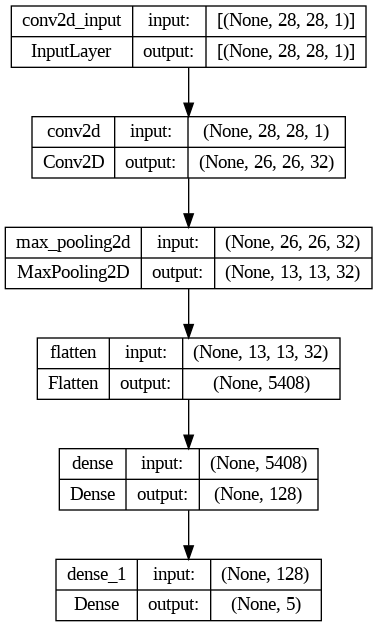

In [ ]:
# Utility function to plot and summarize a model
def print_summarize(model, model_name):
    print(f"Summary of the {model_name}:")
    model.summary()

# Build and visualize each model
basic_model = build_model(train_shape_labels.shape[1])
print_summarize(basic_model, "Basic Model")
plot_model(basic_model, to_file='image.png', show_shapes=True, show_layer_names=True)

# **basic_dropout_model Architecture**

Summary of the Basic_Dropout_Model:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               692352    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                  

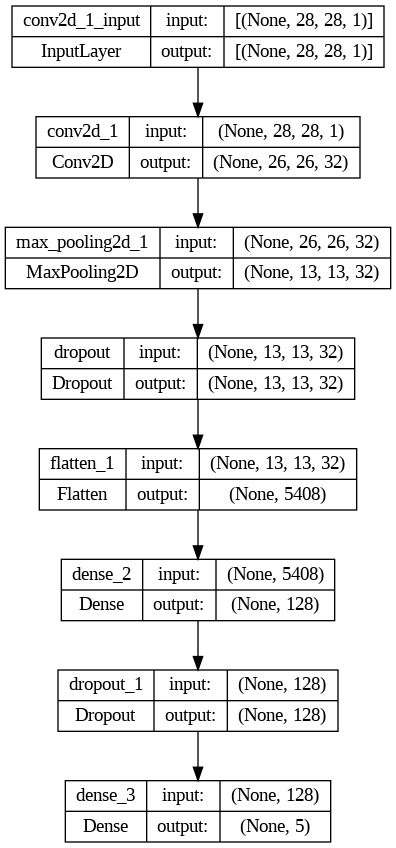

In [ ]:
basic_dropout_model = build_model_basic_dropout(train_shape_labels.shape[1])
print_summarize(basic_dropout_model, "Basic_Dropout_Model")
plot_model(basic_dropout_model, to_file='image.png', show_shapes=True, show_layer_names=True)


# **deeper_batch_norm_model Architecture**

Summary of the Deeper_Batch_Norm_Model:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
              

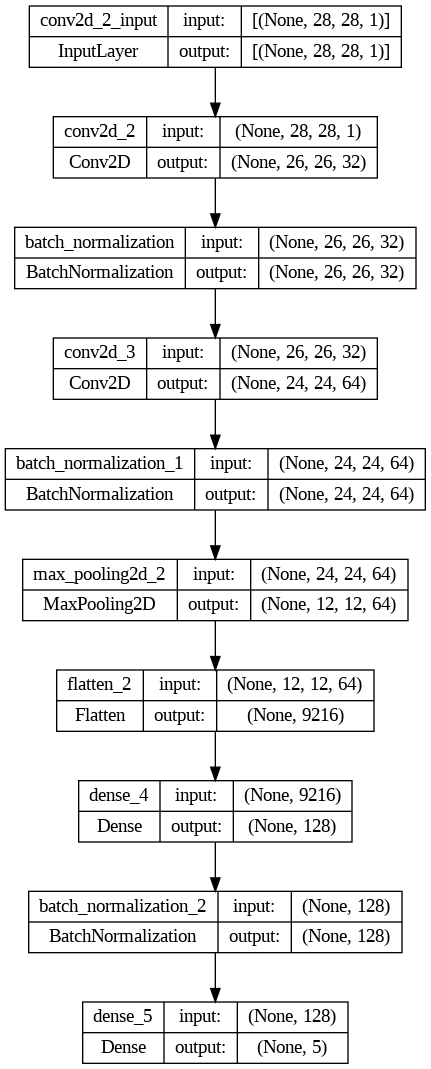

In [ ]:
deeper_batch_norm_model = build_model_deeper_with_batch_norm(train_shape_labels.shape[1])
print_summarize(deeper_batch_norm_model, "Deeper_Batch_Norm_Model")
plot_model(deeper_batch_norm_model, to_file='image.png', show_shapes=True, show_layer_names=True)


# **lenet5_inspired_model Architecture**

Summary of the LeNet5_Inspired_Model:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 12, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 256)               0         
                                                                 
 dense_6 (Dense)

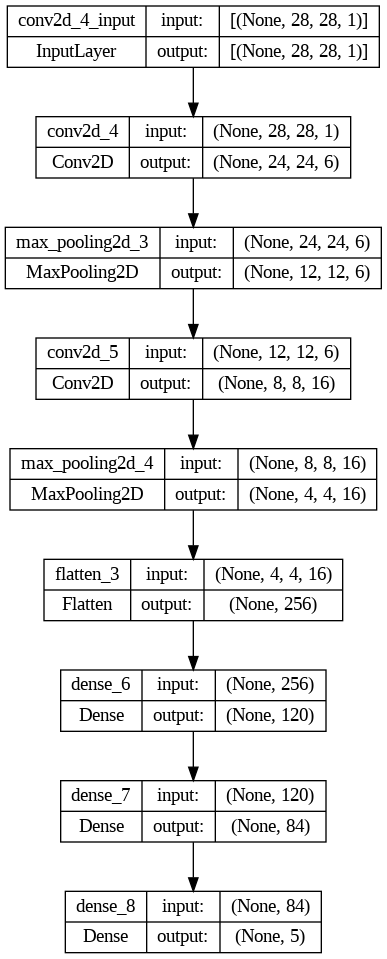

In [ ]:
lenet5_inspired_model = build_model_lenet5_inspired(train_shape_labels.shape[1])
print_summarize(lenet5_inspired_model, "LeNet5_Inspired_Model")
plot_model(lenet5_inspired_model, to_file='image.png', show_shapes=True, show_layer_names=True)


# **inception_like_model Architecture**

Summary of the Inception_Like_Model:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 28, 28, 16)           32        ['input_1[0][0]']             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 28, 28, 16)           32        ['input_1[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 28, 28, 32)           4640      ['conv2d_6[0][0]']            
                                                         

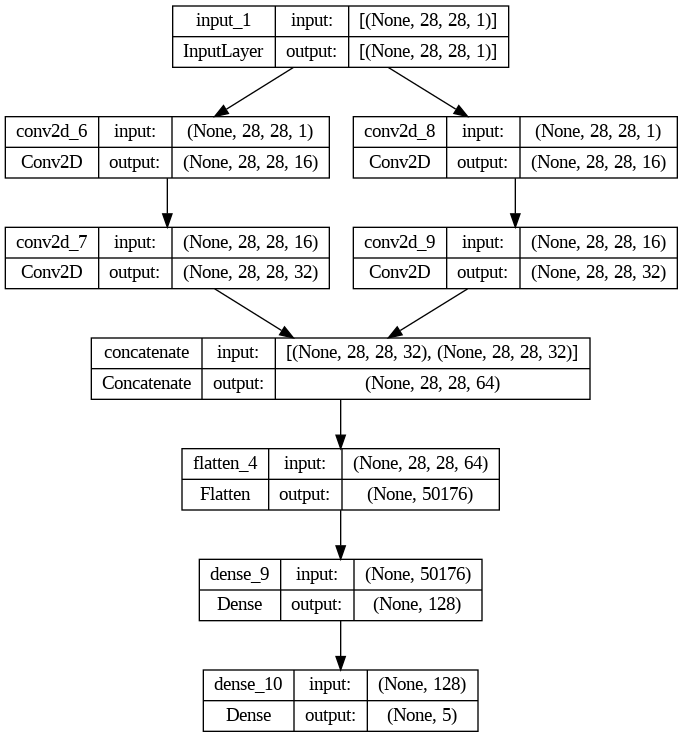

In [ ]:
inception_like_model = build_model_inception_like(train_shape_labels.shape[1])
print_summarize(inception_like_model, "Inception_Like_Model")
plot_model(inception_like_model, to_file='image.png', show_shapes=True, show_layer_names=True)


In [ ]:
def train_models(train_data, train_labels, test_data, test_labels, epochs = 10, batch_size = 32):
    model_functions = [
        build_model,
        build_model_basic_dropout,
        build_model_deeper_with_batch_norm,
        build_model_lenet5_inspired,
        build_model_inception_like
    ]

    # Dictionary to store results
    training_results = {}

    # Train each model and record performance and training time
    for func in model_functions:
        print(f'Start training for the {func.__name__}.........')
        model = func(train_labels.shape[1])
        start_time = time.time()
        history = model.fit(
        train_data,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_data, test_labels)
    )
        end_time = time.time()
        training_time = end_time - start_time

        # Store results
        training_results[func.__name__] = {
            'history': history.history,
            'training_time': training_time
        }
    return training_results

# **Train Model for type Problem**

In [ ]:
type_training_results = train_models(train_data, train_type_labels, test_data, test_type_labels)

Start training for the build_model.........
Epoch 1/10
180/180 [==============================] - 4s 5ms/step - loss: 1.1540 - accuracy: 0.6807 - val_loss: 0.5817 - val_accuracy: 0.8430
Epoch 2/10
180/180 [==============================] - 1s 5ms/step - loss: 0.4366 - accuracy: 0.8815 - val_loss: 0.3837 - val_accuracy: 0.8904
Epoch 3/10
180/180 [==============================] - 1s 5ms/step - loss: 0.2759 - accuracy: 0.9277 - val_loss: 0.2910 - val_accuracy: 0.9225
Epoch 4/10
180/180 [==============================] - 1s 4ms/step - loss: 0.1894 - accuracy: 0.9459 - val_loss: 0.2129 - val_accuracy: 0.9344
Epoch 5/10
180/180 [==============================] - 1s 4ms/step - loss: 0.1319 - accuracy: 0.9653 - val_loss: 0.1852 - val_accuracy: 0.9477
Epoch 6/10
180/180 [==============================] - 1s 4ms/step - loss: 0.1098 - accuracy: 0.9722 - val_loss: 0.1498 - val_accuracy: 0.9546
Epoch 7/10
180/180 [==============================] - 1s 5ms/step - loss: 0.0786 - accuracy: 0.9808 - va

# **Comparison Between Models**

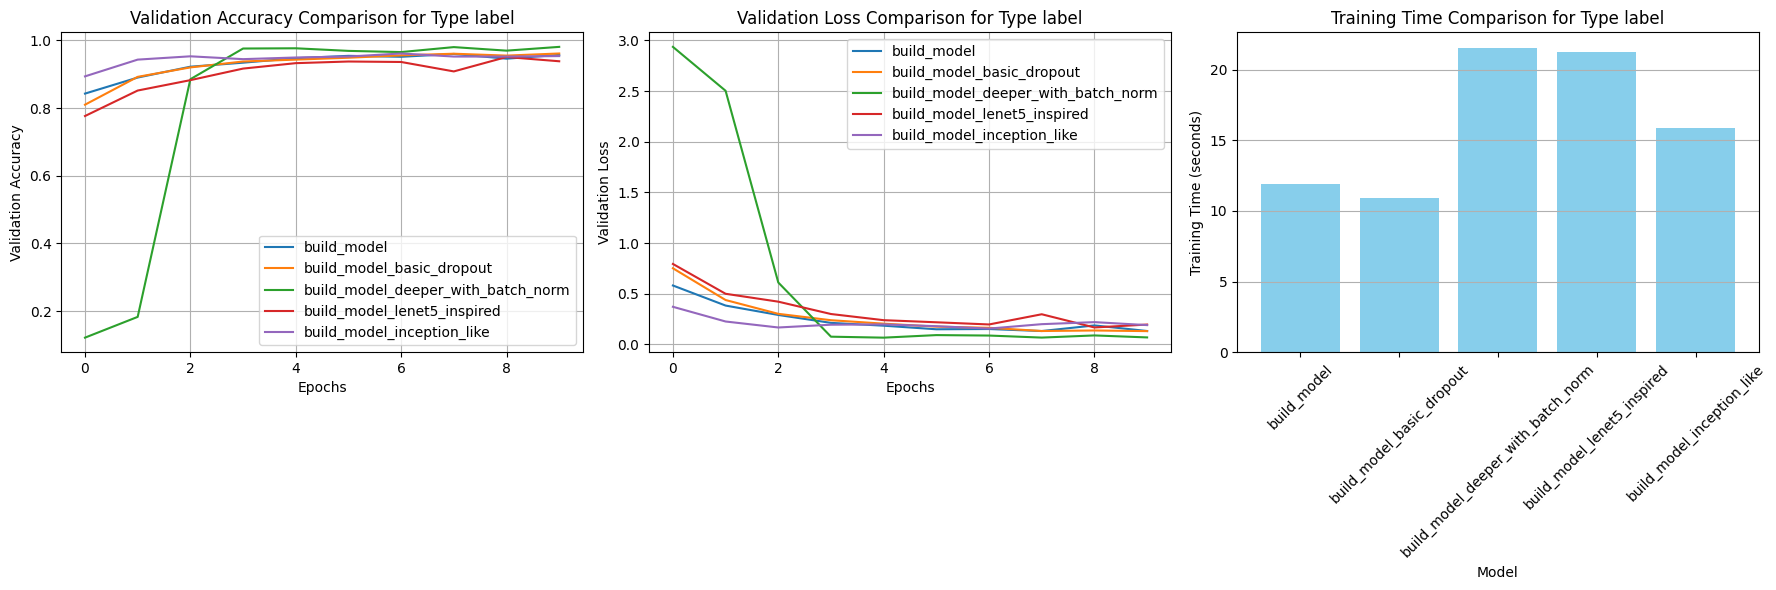

In [ ]:
plt.figure(figsize=(18, 6))

# Plot 1: Validation Accuracy
plt.subplot(1, 3, 1)
for model_name, results in type_training_results.items():
    val_accuracy = results['history']['val_accuracy']
    plt.plot(val_accuracy, label=model_name)
plt.title('Validation Accuracy Comparison for Type label')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot 2: Validation Loss
plt.subplot(1, 3, 2)
for model_name, results in type_training_results.items():
    val_loss = results['history']['val_loss']
    plt.plot(val_loss, label=model_name)
plt.title('Validation Loss Comparison for Type label')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

# Plot 3: Training Time
plt.subplot(1, 3, 3)
model_names = list(type_training_results.keys())
training_times = [results['training_time'] for results in type_training_results.values()]
plt.bar(model_names, training_times, color='skyblue')
plt.title('Training Time Comparison for Type label')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()


# **Train Model for Shape Problem**

In [ ]:
shape_training_results = train_models(train_data, train_shape_labels, test_data, test_shape_labels)

Start training for the build_model.........
Epoch 1/10
180/180 [==============================] - 2s 4ms/step - loss: 0.5172 - accuracy: 0.8371 - val_loss: 0.2116 - val_accuracy: 0.9463
Epoch 2/10
180/180 [==============================] - 1s 4ms/step - loss: 0.1688 - accuracy: 0.9513 - val_loss: 0.1355 - val_accuracy: 0.9637
Epoch 3/10
180/180 [==============================] - 1s 4ms/step - loss: 0.0965 - accuracy: 0.9747 - val_loss: 0.0870 - val_accuracy: 0.9763
Epoch 4/10
180/180 [==============================] - 1s 4ms/step - loss: 0.0652 - accuracy: 0.9832 - val_loss: 0.0659 - val_accuracy: 0.9791
Epoch 5/10
180/180 [==============================] - 2s 9ms/step - loss: 0.0427 - accuracy: 0.9883 - val_loss: 0.0529 - val_accuracy: 0.9819
Epoch 6/10
180/180 [==============================] - 2s 11ms/step - loss: 0.0321 - accuracy: 0.9937 - val_loss: 0.0702 - val_accuracy: 0.9742
Epoch 7/10
180/180 [==============================] - 1s 8ms/step - loss: 0.0285 - accuracy: 0.9930 - v

# **Comparison Between Model**

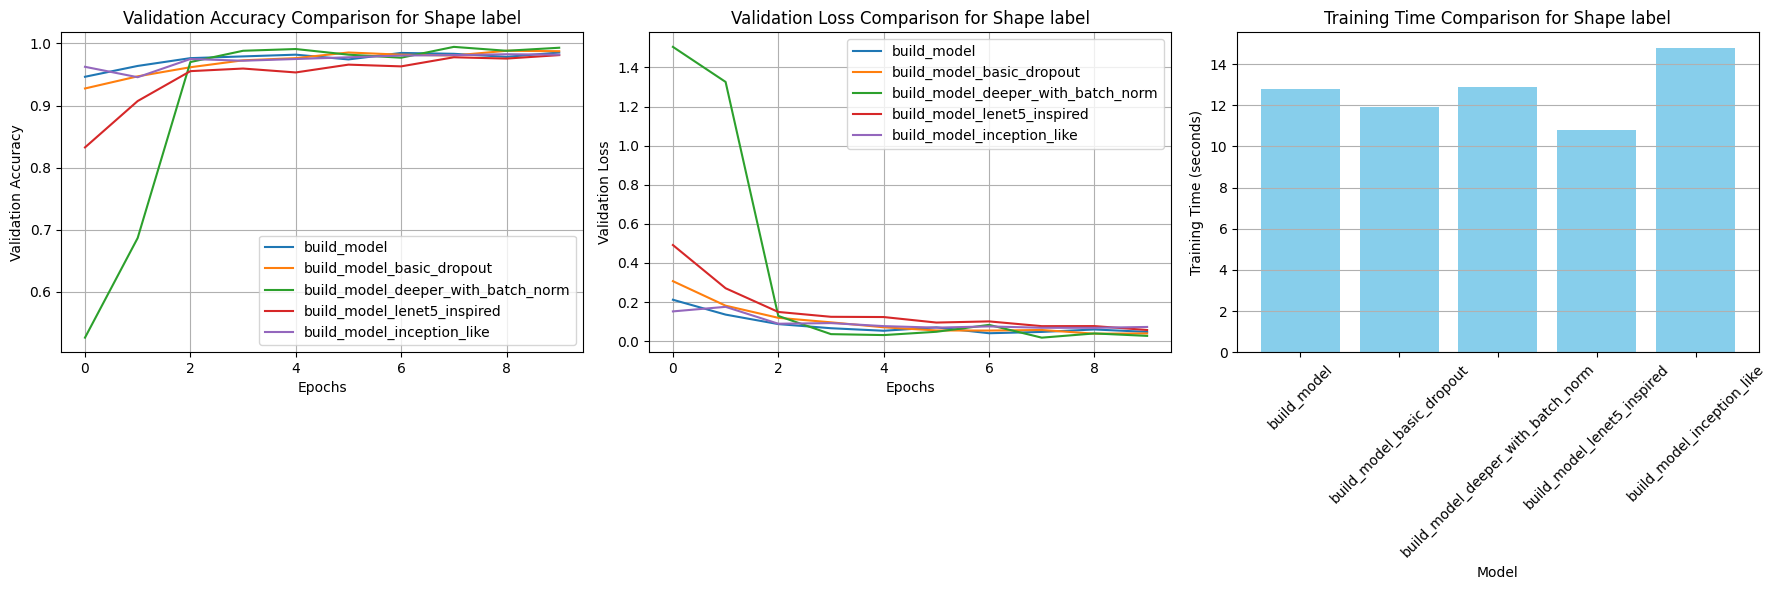

In [ ]:
plt.figure(figsize=(18, 6))

# Plot 1: Validation Accuracy
plt.subplot(1, 3, 1)
for model_name, results in shape_training_results.items():
    val_accuracy = results['history']['val_accuracy']
    plt.plot(val_accuracy, label=model_name)
plt.title('Validation Accuracy Comparison for Shape label')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot 2: Validation Loss
plt.subplot(1, 3, 2)
for model_name, results in shape_training_results.items():
    val_loss = results['history']['val_loss']
    plt.plot(val_loss, label=model_name)
plt.title('Validation Loss Comparison for Shape label')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

# Plot 3: Training Time
plt.subplot(1, 3, 3)
model_names = list(shape_training_results.keys())
training_times = [results['training_time'] for results in shape_training_results.values()]
plt.bar(model_names, training_times, color='skyblue')
plt.title('Training Time Comparison for Shape label')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()


# **Apply Hyperparameter Tuning on Best Performing Model**

In [ ]:
def model_builder(hp, num_classes):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Hyperparameters to tune
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])

    if hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Setting up the tuner
def setup_tuner(num_classes):
    return RandomSearch(
        lambda hp: model_builder(hp, num_classes),
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
    )


In [ ]:
num_classes_shape = train_shape_labels.shape[1]
tuner = setup_tuner(num_classes_shape)

# Early stopping to avoid overfitting
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter tuning
tuner.search(train_data, train_shape_labels, epochs=10, validation_data=(test_data, test_shape_labels), callbacks=[stop_early])

# Get the optimal hyperparameters after the search is complete
shape_best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best learning rate for shape: {shape_best_hps.get('learning_rate')}
The best optimizer for shape: {shape_best_hps.get('optimizer')}
""")


Trial 10 Complete [00h 00m 28s]
val_accuracy: 0.9665038287639618

Best val_accuracy So Far: 0.9951151311397552
Total elapsed time: 00h 06m 20s

The best learning rate for shape: 0.0009428270474423584
The best optimizer for shape: adam



In [ ]:
directory_path = '/content/untitled_project'

# Check if the directory exists
if os.path.exists(directory_path):
    # Remove the directory and all its contents
    shutil.rmtree(directory_path)
    print(f"Directory '{directory_path}' has been removed.")
else:
    print(f"Directory '{directory_path}' does not exist.")


Directory '/content/untitled_project' has been removed.


In [ ]:
num_classes_shape = train_type_labels.shape[1]
tuner = setup_tuner(num_classes_shape)

# Early stopping to avoid overfitting
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter tuning
tuner.search(train_data, train_type_labels, epochs=10, validation_data=(test_data, test_type_labels), callbacks=[stop_early])

# Get the optimal hyperparameters
type_best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best learning rate for type: {type_best_hps.get('learning_rate')}
The best optimizer for type: {type_best_hps.get('optimizer')}
""")

Trial 10 Complete [00h 00m 30s]
val_accuracy: 0.9780181348323822

Best val_accuracy So Far: 0.9877878725528717
Total elapsed time: 00h 05m 50s

The best learning rate for type: 0.0009949106476447895
The best optimizer for type: adam



# **Final Model Training**

In [ ]:
def final_model(num_classes):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0009)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
shape_model = final_model(train_shape_labels.shape[1])
# Training the shape model
history_shape = shape_model.fit(
    train_data,
    train_shape_labels,
    epochs=10,
    batch_size=32,
    validation_data=(test_data, test_shape_labels)
)



Epoch 1/10
180/180 [==============================] - 4s 10ms/step - loss: 0.2596 - accuracy: 0.9216 - val_loss: 1.7598 - val_accuracy: 0.5101
Epoch 2/10
180/180 [==============================] - 1s 6ms/step - loss: 0.0562 - accuracy: 0.9839 - val_loss: 2.2076 - val_accuracy: 0.5192
Epoch 3/10
180/180 [==============================] - 1s 7ms/step - loss: 0.0216 - accuracy: 0.9951 - val_loss: 0.4207 - val_accuracy: 0.8493
Epoch 4/10
180/180 [==============================] - 1s 6ms/step - loss: 0.0104 - accuracy: 0.9976 - val_loss: 0.0332 - val_accuracy: 0.9888
Epoch 5/10
180/180 [==============================] - 1s 6ms/step - loss: 0.0140 - accuracy: 0.9956 - val_loss: 0.0431 - val_accuracy: 0.9860
Epoch 6/10
180/180 [==============================] - 1s 6ms/step - loss: 0.0133 - accuracy: 0.9967 - val_loss: 0.0251 - val_accuracy: 0.9916
Epoch 7/10
180/180 [==============================] - 1s 6ms/step - loss: 0.0147 - accuracy: 0.9953 - val_loss: 0.0408 - val_accuracy: 0.9867
Epoch

In [ ]:
shape_model.save('shape_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Plotting**

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualizing predictions
def visualize_predictions(model, data, true_labels, label_encoder):
    predictions = model.predict(data)
    plt.figure(figsize=(15, 10))
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        plt.title(f"Predicted: {label_encoder.inverse_transform([predictions[i].argmax()])[0]}\nTrue: {label_encoder.inverse_transform([true_labels[i].argmax()])[0]}")
        plt.axis('off')
    plt.show()

def plot_confusion_matrix(model, test_data, test_labels):
    predictions = model.predict(test_data)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

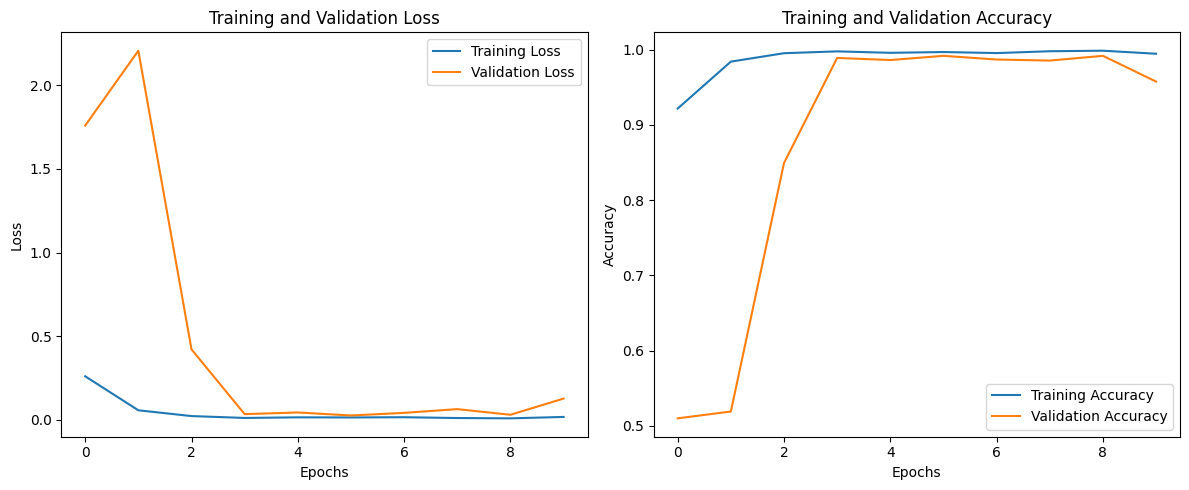

In [ ]:
plot_history(history_shape)


# **Evaluation**

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = shape_model.evaluate(test_data, test_shape_labels, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

45/45 - 0s - loss: 0.1262 - accuracy: 0.9574 - 126ms/epoch - 3ms/step
Test Loss: 0.1262291967868805
Test Accuracy: 0.957431972026825


# **Confusion Matrix**

45/45 [==============================] - 0s 2ms/step


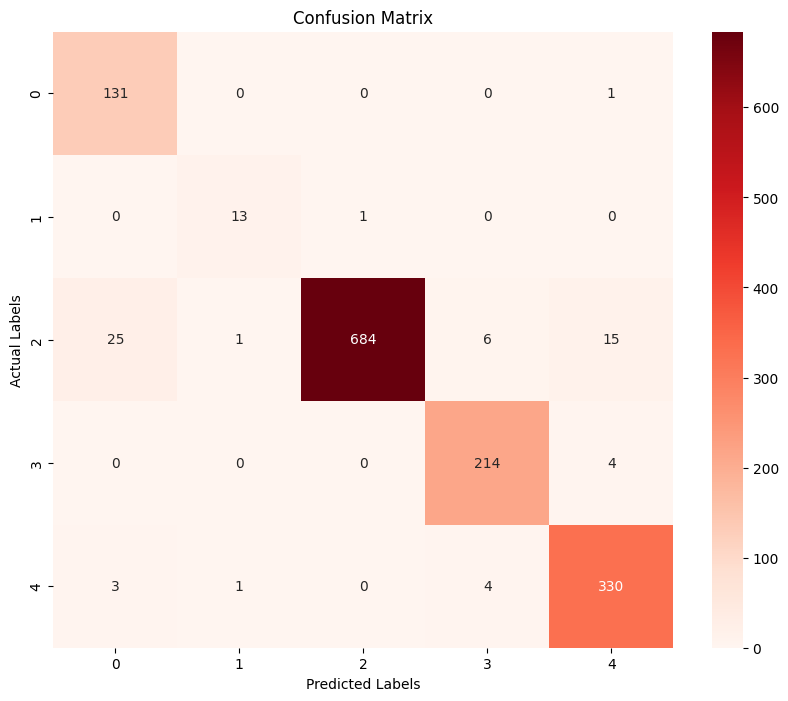

In [ ]:
plot_confusion_matrix(shape_model, test_data, test_shape_labels)

# **Prediction**

45/45 [==============================] - 0s 2ms/step


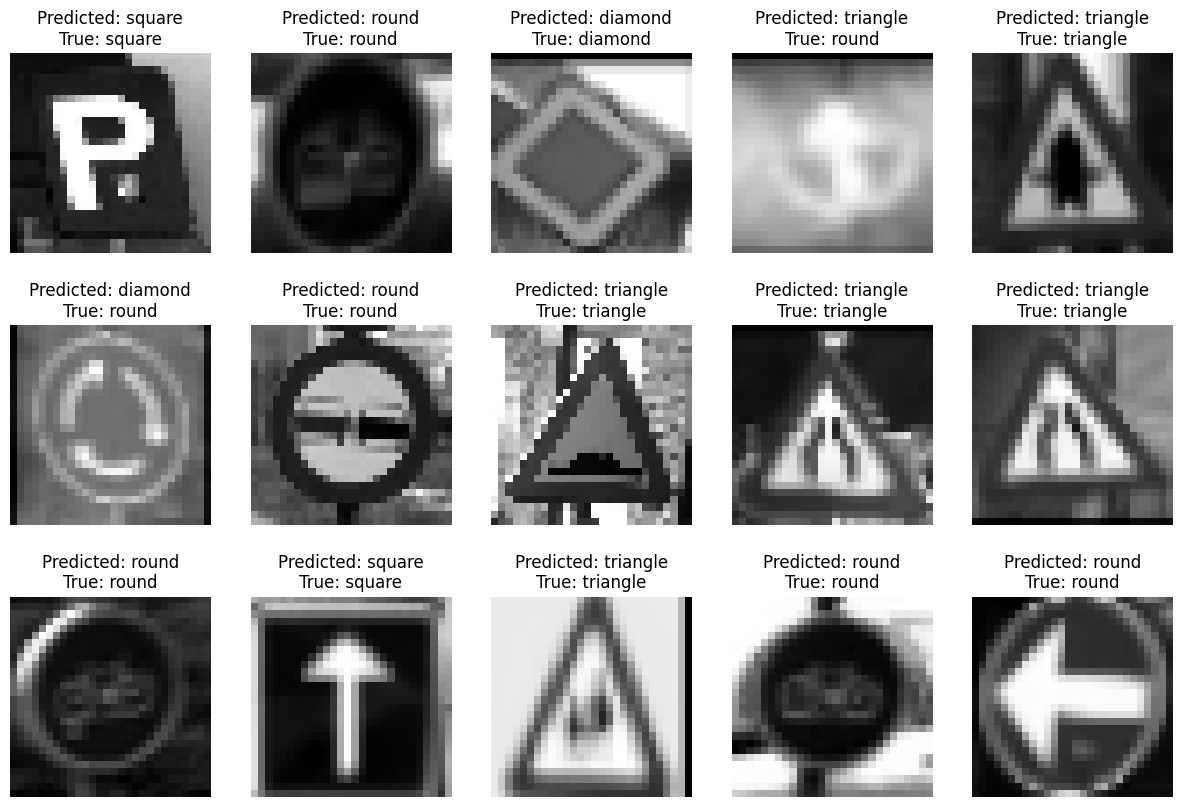

In [ ]:
visualize_predictions(shape_model, test_data, test_shape_labels, shape_encoder)

In [ ]:
type_model = final_model(train_type_labels.shape[1])
# Training the type model
history_type = type_model.fit(
    train_data,
    train_type_labels,
    epochs=10,
    batch_size=32,
    validation_data=(test_data, test_type_labels)
)

Epoch 1/10
180/180 [==============================] - 5s 15ms/step - loss: 0.4180 - accuracy: 0.8853 - val_loss: 3.7874 - val_accuracy: 0.0761
Epoch 2/10
180/180 [==============================] - 2s 12ms/step - loss: 0.0848 - accuracy: 0.9791 - val_loss: 3.3895 - val_accuracy: 0.1061
Epoch 3/10
180/180 [==============================] - 2s 11ms/step - loss: 0.0339 - accuracy: 0.9927 - val_loss: 0.6430 - val_accuracy: 0.8248
Epoch 4/10
180/180 [==============================] - 2s 11ms/step - loss: 0.0196 - accuracy: 0.9949 - val_loss: 0.1016 - val_accuracy: 0.9714
Epoch 5/10
180/180 [==============================] - 2s 12ms/step - loss: 0.0162 - accuracy: 0.9963 - val_loss: 0.0594 - val_accuracy: 0.9812
Epoch 6/10
180/180 [==============================] - 2s 9ms/step - loss: 0.0107 - accuracy: 0.9983 - val_loss: 0.0656 - val_accuracy: 0.9846
Epoch 7/10
180/180 [==============================] - 2s 11ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0452 - val_accuracy: 0.9853


In [ ]:
type_model.save('type_model.h5')


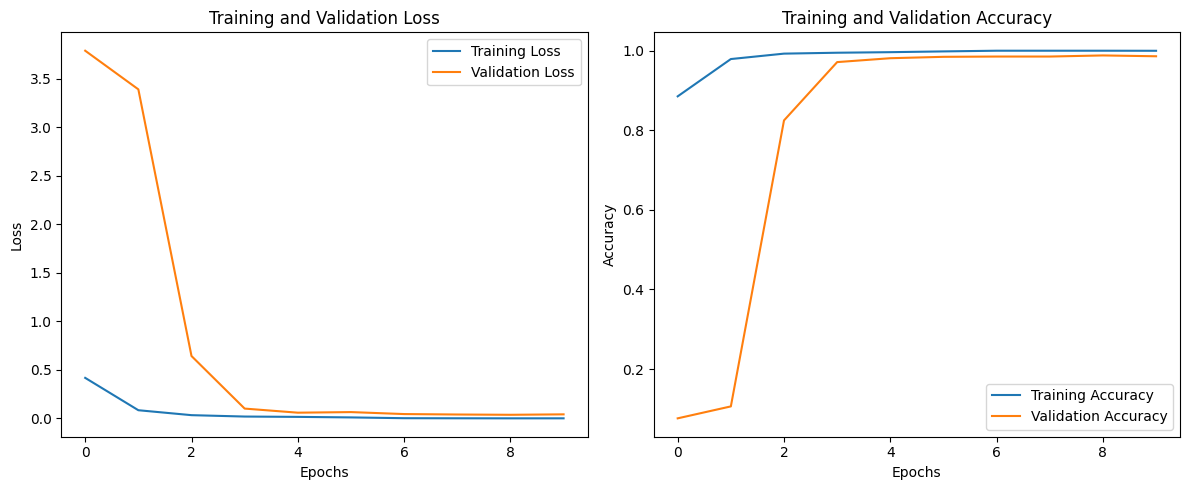

In [ ]:
plot_history(history_type)


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = type_model.evaluate(test_data, test_type_labels, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

45/45 - 0s - loss: 0.0423 - accuracy: 0.9860 - 148ms/epoch - 3ms/step
Test Loss: 0.04226171225309372
Test Accuracy: 0.9860432744026184


45/45 [==============================] - 0s 4ms/step


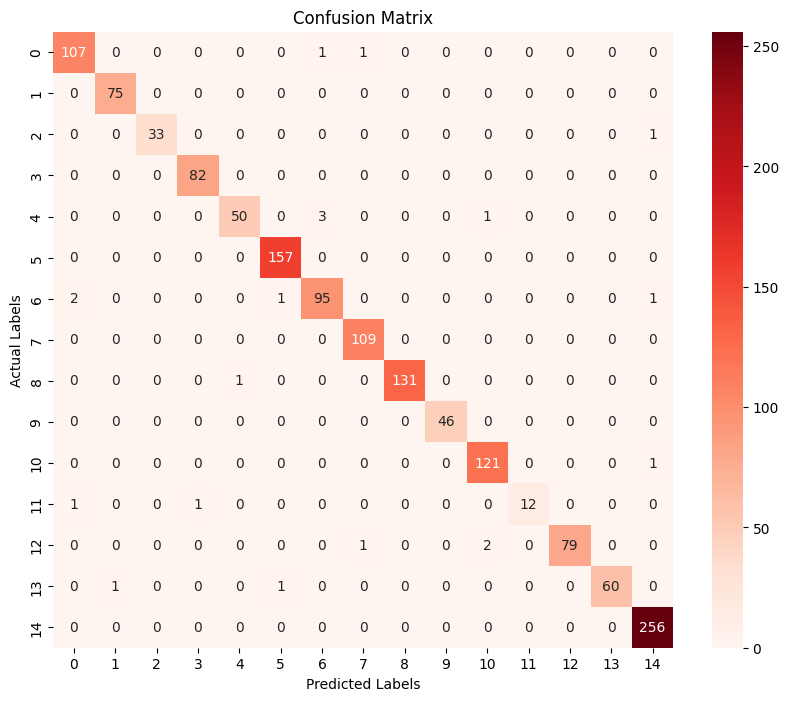

In [ ]:
plot_confusion_matrix(type_model, test_data, test_type_labels)

45/45 [==============================] - 1s 4ms/step


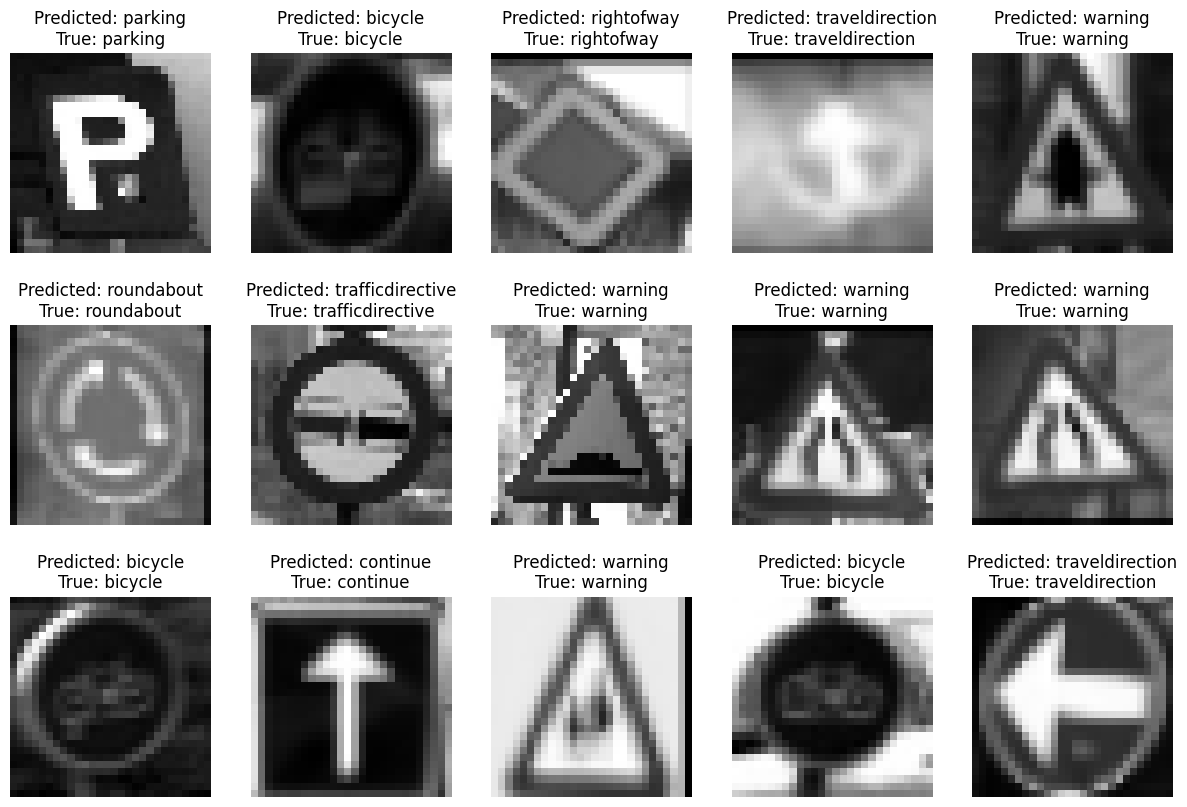

In [ ]:
visualize_predictions(type_model, test_data, test_type_labels, type_encoder)

# **Inference**

In [ ]:
def preprocess_image(image_path):
    """
    Load and preprocess an image.
    """
    img = Image.open(image_path)
    img = img.resize((28, 28))  # Assuming the model takes 28x28 input
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Model expects a batch of images
    return img_array

def predict_image(model, image_array):
    """
    Predict the class of an image using a model.
    """
    predictions = model.predict(image_array)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class

def decode_prediction(predicted_class, encoder):
    """
    Decode the prediction using the label encoder.
    """
    human_readable_label = encoder.inverse_transform(predicted_class)
    return human_readable_label

# Function to handle the inference mechanism
def perform_inference(model, encoder, image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)

    # Predict the image
    predicted_class = predict_image(model, img_array)

    # Decode the prediction
    label = decode_prediction(predicted_class, encoder)

    print(f"The predicted label is: {label[0]}")





# **Shape Prediction**

In [ ]:
image_path = '/content/trafficsigns_dataset/diamond/rightofway/00032_00000.png'
shape_model = keras.models.load_model('shape_model.h5')
shape_encoder = joblib.load('shape_encoder.pkl')
perform_inference(shape_model, shape_encoder, image_path)

1/1 [==============================] - 0s 148ms/step
The predicted label is: diamond


# **Type Prediction**

In [ ]:
image_path = '/content/trafficsigns_dataset/diamond/rightofway/00032_00000.png'
type_model = keras.models.load_model('type_model.h5')
type_encoder = joblib.load('type_encoder.pkl')
perform_inference(type_model, type_encoder, image_path)

1/1 [==============================] - 0s 94ms/step
The predicted label is: rightofway
